In [1]:

from google.colab import drive
drive.mount('/content/drive')

root_path = '/content/drive/MyDrive/CVDL'
dumps_path =  f"{root_path}/dumps/"
dataset  = f"{root_path}/dataset/"

!cp "$root_path/modules/lib.py" .
!cp "$root_path/modules/plots.py" .
!cp "$root_path/modules/metrics.py" .


Mounted at /content/drive


# Preprocessing

## Imports

In [2]:
import cv2
import pickle
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import tensorflow as tf
import importlib
from datetime import datetime

from keras.initializers import glorot_uniform

import lib
import plots
import metrics

tf.keras.backend.clear_session()

## Parameters

In [3]:
# Deafault Res: 606x468 (ar 101 : 78)

# Tested Res's:
# 224x160 (ar 7 : 5)
# 384x288
# 576x432
# 512x384
input_res = (384, 288)

seed = 42

params = {
          'x':input_res[0],                                
          'y':input_res[1],                                
          'batch_size': 8,                        
          'n_channels_mask': 1,                            
          'n_channels': 1,                        
          'shuffle': True,              
          'learningRate': 1e-3,                      
          'momentum': 0.98,                        
          'nEpoches': 100,                        
          }

ratio_test = 0.85
ratio_val  = 0.8

lib.create_dump([params, seed], dumps_path + "params_du")

type_ds  = ['Images','Masks']
modality = ['train','validation','test']

# get path Img and Mask
path_img  = os.path.join(dataset, type_ds[0])
path_msk  = os.path.join(dataset, type_ds[1])
path_     = [path_img, path_msk]

# get length imgs and proof that is equal with masks
length_imgs  = len(os.listdir(os.path.join(dataset,type_ds[0] + "/"))) 
length_masks = len(os.listdir(os.path.join(dataset,type_ds[1] + "/")))
params['length_data'] = length_imgs,

# get name of file imgs
imgs_list_path = os.listdir(path_img)

## Data loading 

In [4]:
# LOAD & SPLIT DATA ============================================================
'''
mode = 1  # mode = 0: Random Split
          # mode = 1: Split for Patients
          
dataset_list = lib.get_dataset_list(
                                mode, 
                                path_, 
                                imgs_list_path, 
                                params, 
                                ratio_test, 
                                ratio_val, 
                                seed, 
                                modality)

# Dumping splitted data
lib.create_dump(dataset_list, f"{dumps_path}data_rt{ratio_test}_rv{ratio_val}_{input_res[0]}x{input_res[1]}")

'''

'\nmode = 1  #\xa0mode = 0: Random Split\n          #\xa0mode = 1: Split for Patients\n          \ndataset_list = lib.get_dataset_list(\n                                mode, \n                                path_, \n                                imgs_list_path, \n                                params, \n                                ratio_test, \n                                ratio_val, \n                                seed, \n                                modality)\n\n# Dumping splitted data\nlib.create_dump(dataset_list, f"{dumps_path}data_rt{ratio_test}_rv{ratio_val}_{input_res[0]}x{input_res[1]}")\n\n'

##Loading Data from Pickle

In [5]:
dataset_list = pickle.load(open( f"{dumps_path}data_rt{ratio_test}_rv{ratio_val}_{input_res[0]}x{input_res[1]}", "rb" ))

##Data Augmentation

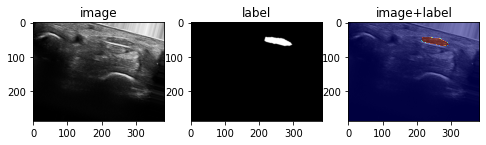

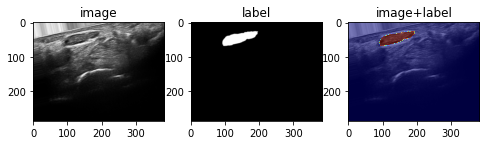

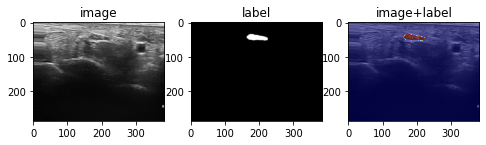

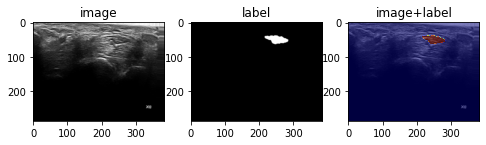

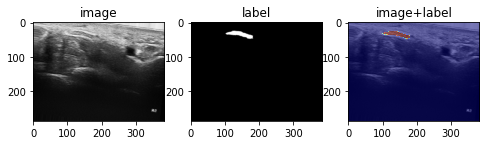

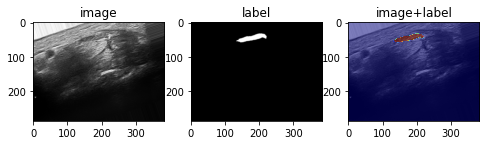

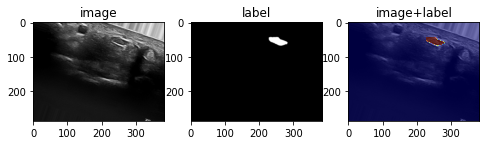

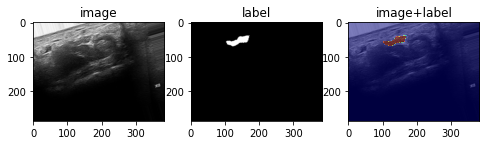

In [6]:
# DATA AUGMENTATION ============================================================
train_generator, val_generator = lib.data_augmentation(seed, dataset_list, params)

params["length_training"]   = len(dataset_list[0]['train'])
params['length_validation'] = len(dataset_list[0]['validation'])

augmented_batch_plot = plots.plot_augmented_batch(train_generator)
plt.show()

In [7]:
print(params["length_training"])
print(params['length_validation'])
print(len(dataset_list[0]['test']))

164
38
44


# Model definition & training

## Training

In [ ]:
params['learningRate'] = 1e-2
params['nEpoches'] = 100


models_name = ['unet', 'lightweight_unet', 'dbunet', 'dbunet_BNDrop', 'dbunet_BN']
arch_name = models_name[0]
model_weights = f"{root_path}/dataset/results/models/{arch_name}_e{params['nEpoches']}_lr{params['learningRate']}"
!rm -rf $model_weights

log_path = f"{model_weights}/logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
!rm -rf $log_path
!cp "$root_path/modules/models/{arch_name}.py" .
arch = importlib.import_module(arch_name)
'''if 'dbunet' in arch_name:
  model = arch.build_model(input_size)
else:'''


input_size = (input_res[1], input_res[0], 1)
initializer = tf.keras.initializers.GlorotUniform()
model = arch.build_model(initializer, input_size)
#model.summary()

In [ ]:
# Model savepath
#now = datetime.now()
#current_time = now.strftime("%H:%M:%S")

# Default loss, metric
#loss = 'binary_crossentropy'
#metric = 'accuracy'
loss      = metrics.bce_dice_loss
recall    = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()
metric    = [metrics.dice, metrics.iou, recall, precision]

print(f'Model wil be saved in {model_weights}')

train_history, model = lib.train(model_weights, log_path, params, model, loss, metric, train_generator, val_generator)


Model wil be saved in /content/drive/MyDrive/CVDL/dataset/results/models/unet_e100_lr0.01
Epoch 1/100
21/21 [==============================] - 14s 375ms/step - loss: 0.9436 - dice: 0.1827 - iou: 4.2130e-04 - recall: 0.0266 - precision: 0.0095 - val_loss: 9.2108 - val_dice: 0.0221 - val_iou: 9.2904e-09 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00

Epoch 00001: val_loss improved from inf to 9.21080, saving model to /content/drive/MyDrive/CVDL/dataset/results/models/unet_e100_lr0.01/Model.hdf5
Epoch 2/100
21/21 [==============================] - 4s 205ms/step - loss: 0.6568 - dice: 0.3777 - iou: 0.1100 - recall: 0.1511 - precision: 0.6172 - val_loss: 1.6921 - val_dice: 0.0224 - val_iou: 0.0115 - val_recall: 1.0000 - val_precision: 0.0120

Epoch 00002: val_loss improved from 9.21080 to 1.69207, saving model to /content/drive/MyDrive/CVDL/dataset/results/models/unet_e100_lr0.01/Model.hdf5
Epoch 3/100
21/21 [==============================] - 4s 203ms/step - loss: 0.6277 - dice: 0.404

## Evaluating

In [8]:
results_tf = model.evaluate(dataset_list[0]['test'], dataset_list[1]['test'], return_dict = True)
train_figure = plots.plot_train_metric(train_history.history, params['nEpoches'], "dice")
plt.show()

NameError: ignored

In [10]:
threshold = 0.5
min_dice = 0.60
results_df, avg = plots.get_results(dataset_list, params, model, threshold)
print(results_df)
print('\n')
print(f"Threshold value: {threshold}")
print(f"Best dice: {max(results_df['dice'])}")
print(f"Average dice: {avg}")
print(f"Minimum requested dice value (bad samples): {min_dice}")
good_res = results_df.loc[(results_df['dice'] >= min_dice)]
print(f"Average dice without bad samples: {good_res['dice'].mean()}")

        dice
0   0.792743
1   0.853874
2   0.761636
3   0.922314
4   0.937095
5   0.904398
6   0.834879
7   0.935678
8   0.922509
9   0.912141
10  0.747493
11  0.907397
12  0.922655
13  0.612403
14  0.773510
15  0.915663
16  0.822447
17  0.375000
18  0.872423
19  0.765565
20  0.819530
21  0.776632
22  0.933411
23  0.936954
24  0.876404
25  0.935504
26  0.880952
27  0.929388
28  0.768473
29  0.938381
30  0.731587
31  0.735733
32  0.874661
33  0.915751
34  0.883203
35  0.858271
36  0.924606
37  0.822718
38  0.878822
39  0.749004
40  0.937649
41  0.906338
42  0.677091
43  0.745136


Threshold value: 0.5
Best dice: 0.9383809907370116
Average dice: {'dice': 0.8392732901688601}
Minimum requested dice value (bad samples): 0.6
Average dice without bad samples: 0.8500703434286011


In [14]:
plots.get_results(dataset_list, params, model, threshold)
print(results_df)
print(f"Average dice: {results_df.loc[(results_df['dice'] >= min_dice)]['dice'].mean()}")

        dice
0   0.792743
1   0.853874
2   0.761636
3   0.922314
4   0.937095
5   0.904398
6   0.834879
7   0.935678
8   0.922509
9   0.912141
10  0.747493
11  0.907397
12  0.922655
13  0.612403
14  0.773510
15  0.915663
16  0.822447
17  0.375000
18  0.872423
19  0.765565
20  0.819530
21  0.776632
22  0.933411
23  0.936954
24  0.876404
25  0.935504
26  0.880952
27  0.929388
28  0.768473
29  0.938381
30  0.731587
31  0.735733
32  0.874661
33  0.915751
34  0.883203
35  0.858271
36  0.924606
37  0.822718
38  0.878822
39  0.749004
40  0.937649
41  0.906338
42  0.677091
43  0.745136
Average dice: 0.8500703434286011


     dice
17  0.375
0.022727272727272728


Loading bad samples... :






Image index 17 - dice: dice    0.375
Name: 17, dtype: float64


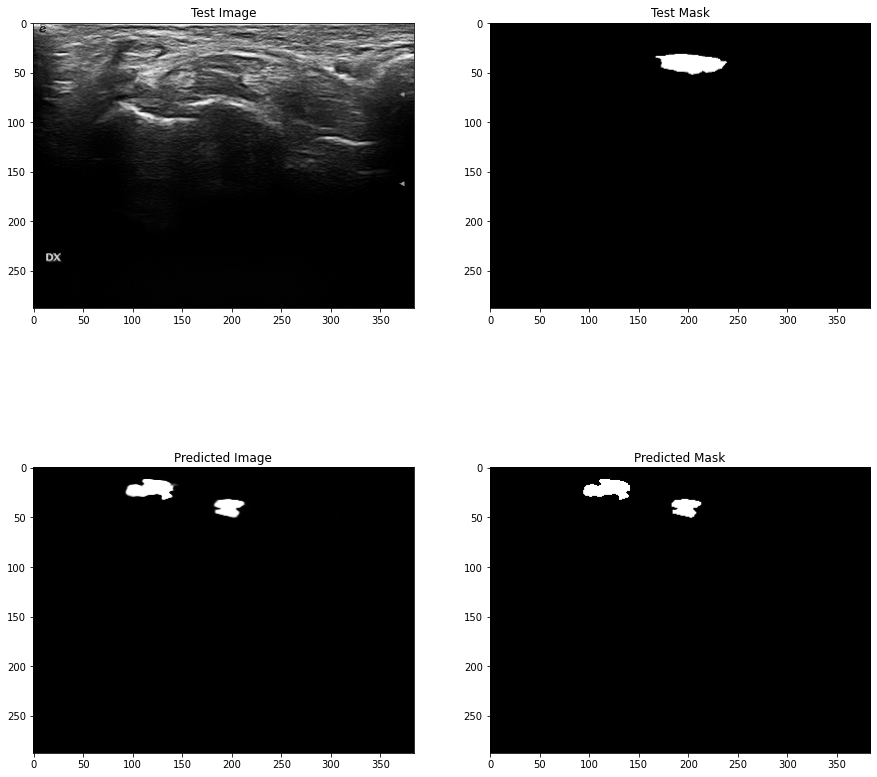

In [11]:
bad_res = results_df.loc[(results_df['dice'] < min_dice)]
print(bad_res)

num = bad_res['dice'].count()
den = results_df['dice'].count()

print(num/den)
print('\n')
print("Loading bad samples... :")
print('\n')
for idx in bad_res.index:
  print('\n')
  print('\n')
  print(f"Image index {idx} - dice: {bad_res.loc[idx]}")
  threshold = 0.5
  test_image = dataset_list[0]['test'][idx,:,:,0]
  test_mask = dataset_list[1]['test'][idx,:,:,0]
  test_results = lib.get_preditcions(test_image, test_mask, params, model, threshold)
  results_figure = plots.plot_test_results(test_results)

  plt.show()
#results_figure.savefig(f'/content/drive/MyDrive/CVDL/trained_models/{name}/bad_samples.png')

## Saving

In [ ]:
name = 'unet_0.8500'
model.save(f'/content/drive/MyDrive/CVDL/trained_models/{name}/model.h5', save_format='h5')
lib.create_dump(train_history.history, f'/content/drive/MyDrive/CVDL/trained_models/{name}/train_history')

In [9]:
from tensorflow import keras

loss      = metrics.bce_dice_loss
recall    = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()
metric    = [metrics.dice, metrics.iou, recall, precision]

name = 'unet_0.8500'
c_objects = {
    "bce_dice_loss": metrics.bce_dice_loss,
    "dice": metrics.dice,
    "iou": metrics.iou,
    "precision": tf.keras.metrics.Precision(),
    "recall": tf.keras.metrics.Recall(),
}

loaded_model = keras.models.load_model(f'/content/drive/MyDrive/CVDL/trained_models/{name}/model.h5', custom_objects=c_objects)
loaded_model.compile(loss=metrics.bce_dice_loss, optimizer='adam', metrics=metric)
results_tf = loaded_model.evaluate(dataset_list[0]['test'], dataset_list[1]['test'], return_dict = True)

model = loaded_model



2/2 [==============================] - 18s 687ms/step - loss: 0.1967 - dice: 0.8235 - iou: 0.7396 - recall: 0.8547 - precision: 0.8075
